# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Kirtika Kandel

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
nhanes

,SEQN,HSD010,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DRQSPREP,DR1STY,DRQSDIET,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TRET,DR1TVARA,DR1TBCAR,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TP182,DR1TP183,DR1TP204,DR1.300,DR1TWS,DRD340,DRD360,PEASCST1,PEASCTM1,BPXPULS,BMDSTATS,BMXWT,BMXHT,BMXBMI,BMXARML,BMXARMC,BMXWAIST,MGDEXSTS,OHDEXSTS,OHDDESTS,OHX01TC,OHX02TC,OHX03TC,OHX04TC,OHX05TC,OHX06TC,OHX07TC,OHX08TC,OHX09TC,OHX10TC,OHX11TC,OHX12TC,OHX13TC,OHX14TC,OHX15TC,OHX16TC,OHX17TC,OHX18TC,OHX19TC,OHX20TC,OHX21TC,OHX22TC,OHX23TC,OHX24TC,OHX25TC,OHX26TC,OHX27TC,OHX28TC,OHX29TC,OHX30TC,OHX31TC,OHX32TC,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,PHQ020,PHQ030,PHQ040,PHQ050,PHQ060,PHAFSTMN.x,LBXHA,LBXHBS,URXVOL1,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMDBORN4,DMDCITZN,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,DMDHHSIZ,DMDFMSIZ,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,CBD070,HSQ500,HSQ510,HSQ520,HSAQUEX,DIQ010,DIQ050,DLQ010,DLQ020,DLQ040,DLQ050,DLQ060,FSD032A,FSD032B,FSD032C,FSDHH,FSDAD,FSD151,FSQ165,FSQ162,HEQ010,HEQ030,HIQ011,HIQ270,HIQ210,HOD050,HOQ065,HUQ010,HUQ020,HUQ030,HUQ041,HUQ071,HUQ090,IMQ011,IMQ020,INQ020,INQ012,INQ030,INQ060,INQ080,INQ090,INQ132,INQ140,INQ150,IND235,INDFMMPI,INDFMMPC,MCQ010,MCQ053,MCQ082,MCQ086,MCQ092,MCQ203,MCQ300B,OHQ030,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
0,73568,1,1,87,2,2,12,7,1,1,13,1,3,2,2,30,3145,139.21,227.63,83.91,37.6,172.21,66.642,57.929,32.571,629,17.45,868,1427,5699,1447,1.877,2.915,23.003,3.275,364,0,364,364,658.1,9.59,77.5,5.9,73.1,2137,2361,604,15.20,20.51,2.645,4444,4307,122.5,6643.36,1.759,0.875,1.083,1.748,3.984,7.733,32.676,13.089,2.258,47.321,0.529,27.340,4.643,0.266,2,2,1,2,1,585,1,1,47.1,152.5,20.3,32.6,25.8,73.7,1,1,1,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4,25.0,25.0,31,2740.4,80.65,6.0,20.9,7.7,70.1,0.8,0.7,1.3,0.5,4.2,4.81,15.1,44.2,91.9,31.3,34.1,13.1,231,9.3,2,2,2,2,2,51,1,1,278,8,2,2,26,3,3,2,1,1,1,2,2,1,2,2,3,3,2,26,1,5,5,89514.433218,91523.516048,2,113,15,15,5.00,662,2,2,2,2,2,2,2,2,2,2,2,3,3,3,1,1,2,2,2,2,2,1,1,2,7,1,1,3,1,2,2,2,3,1,1,2,2,2,2,2,2,1,2,9,3.03,3,2,2,2,2,2,2,2,2,1,2,2,1,2,1,1,2,2,2
1,73576,1,1,49,2,1,23,6,1,1,13,4,1,2,2,6,1012,48.91,145.46,44.67,4.0,25.14,7.143,8.835,6.313,111,1.45,2,2,1,9,1.081,0.741,14.930,0.714,150,76,74,202,172.7,3.27,27.5,0.1,17.4,337,558,92,9.51,9.43,0.467,2351,786,77.3,1256.54,0.007,0.004,0.003,0.010,0.016,0.372,3.921,1.870,0.466,3.094,0.080,5.481,0.365,0.034,2,99,2,2,1,584,1,1,67.3,170.4,23.2,37.0,30.7,74.2,1,1,1,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5.0,5.0,166,14674.4,3.01,5.1,35.0,8.0,53.2,3.1,0.7,1.8,0.4,2.7,4.79,14.5,43.2,90.1,30.2,33.5,12.6,284,7.8,2,2,2,2,2,13,2,2,98,8,2,1,16,4,4,2,1,1,1,2,2,1,2,2,6,6,2,35,1,4,77,12433.748735,12665.770090,1,104,8,8,1.58,1000,2,2,2,2,2,2,2,2,2,2,2,2,2,3,2,2,2,1,2,2,2,1,1,2,9,2,1,1,1,2,2,2,1,1,1,2,2,2,2,2,2,2,1,5,0.76,1,2,2,2,2,2,2,2,1,1,2,1,1,2,1,1,2,1,1
2,73579,2,1,59,2,2,34,1,1,1,13,1,3,2,2,15,1711,81.54,211.42,82.71,11.0,60.80,25.869,19.464,11.279,149,4.42,624,651,351,187,1.869,2.268,20.340,0.911,363,193,171,500,224.8,5.02,12.7,8.0,40.7,1612,1522,227,11.17,9.22,0.642,3295,1925,111.2,1027.78,0.915,0.487,0.296,0.694,0.786,2.961,13.100,5.772,0.831,17.575,0.243,9.591,1.307,0.061,2,1,2,1,1,648,1,1,40.2,161.0,15.5,34.4,21.8,62.6,1,1,1,4,4,2,1,2,2,2,2,2,2,2,2,2,2,4,4,4,4,2,2,2,2,2,2,2,2,2,2,2,2,4,4,1.2,1.2,19,1679.6,6

In [3]:
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DRQSPREP,DR1STY,DRQSDIET,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TRET,DR1TVARA,DR1TBCAR,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TP182,DR1TP183,DR1TP204,DR1.300,DR1TWS,DRD340,DRD360,PEASCST1,PEASCTM1,BPXPULS,BMDSTATS,BMXWT,BMXHT,BMXBMI,BMXARML,BMXARMC,BMXWAIST,MGDEXSTS,OHDEXSTS,OHDDESTS,OHX01TC,OHX02TC,OHX03TC,OHX04TC,OHX05TC,OHX06TC,OHX07TC,OHX08TC,OHX09TC,OHX10TC,OHX11TC,OHX12TC,OHX13TC,OHX14TC,OHX15TC,OHX16TC,OHX17TC,OHX18TC,OHX19TC,OHX20TC,OHX21TC,OHX22TC,OHX23TC,OHX24TC,OHX25TC,OHX26TC,OHX27TC,OHX28TC,OHX29TC,OHX30TC,OHX31TC,OHX32TC,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,PHQ020,PHQ030,PHQ040,PHQ050,PHQ060,PHAFSTMN.x,LBXHA,LBXHBS,URXVOL1,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMDBORN4,DMDCITZN,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,DMDHHSIZ,DMDFMSIZ,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,CBD070,HSQ500,HSQ510,HSQ520,HSAQUEX,DIQ010,DIQ050,DLQ010,DLQ020,DLQ040,DLQ050,DLQ060,FSD032A,FSD032B,FSD032C,FSDHH,FSDAD,FSD151,FSQ165,FSQ162,HEQ010,HEQ030,HIQ011,HIQ270,HIQ210,HOD050,HOQ065,HUQ010,HUQ020,HUQ030,HUQ041,HUQ071,HUQ090,IMQ011,IMQ020,INQ020,INQ012,INQ030,INQ060,INQ080,INQ090,INQ132,INQ140,INQ150,IND235,INDFMMPI,INDFMMPC,MCQ010,MCQ053,MCQ082,MCQ086,MCQ092,MCQ203,MCQ300B,OHQ030,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,-0.171477,0.397914,0.414803,2.500697,1.107522,1.284273,-0.214971,-0.373674,2.034512,1.986901,2.588794,1.773847,0.961022,1.425201,0.942926,1.386541,1.533060,0.815263,0.014052,0.288551,0.660976,-0.140881,0.706619,-0.098435,-0.907666,1.045707,-0.391956,1.652805,0.998991,0.043480,0.295117,-0.223171,2.135037,1.432460,2.052804,0.097031,1.397398,2.051098,0.534889,1.542555,0.106505,2.569728,2.679571,1.914183,3.412428,2.888262,2.739699,3.182787,2.220303,1.752726,1.561064,1.395735,0.739882,0.815964,2.166626,0.745886,-0.204228,-0.232913,-0.819626,0.936311,-0.022017,-1.128613,-0.091131,-0.178885,-1.312358,-1.458155,-1.001972,-1.527091,-1.059293,-1.090878,-0.158408,-0.180406,-0.029544,0.427751,-0.463538,-0.42299,-0.369109,-0.436159,-0.290374,-0.323268,-0.310165,-0.309761,-0.308288,-0.272438,-0.445291,-0.352049,-0.426426,-0.463002,0.429959,0.470258,-0.483734,-0.496306,-0.299087,-0.33179,-0.208547,-0.232923,-0.240994,-0.246759,-0.231989,-0.208547,-0.334028,-0.302111,-0.483127,-0.468451,0.470586,-0.052389,-0.052389,-1.199649,-1.199649,0.182940,-0.555707,-1.333855,-0.176619,1.458874,-0.944739,-0.057331,-1.392130,-0.366430,0.015314,0.242199,0.853112,0.807004,0.697155,0.681519,0.334935,-0.410508,-0.254192,0.956014,0.117271,0.079614,0.211032,0.069775,0.101385,1.235041,-1.003884,-1.540308,1.919006,0.0,0.0,0.888010,-0.487692,-0.145146,-0.239686,0.967580,-0.464271,-0.254981,-0.256057,0.488769,0.14058,-0.188745,0.022017,0.14058,-0.636590,-0.550755,0.993240,-1.576641,-0.170395,1.094998,0.598606,1.592201,1.573579,1.046629,0.507972,1.210424,1.239744,1.412214,-0.070925,0.372925,0.225647,0.03784,0.0,0.155599,0.162342,0.144339,0.196855,0.286187,0.284946,0.15098,0.580442,0.518772,0.46517,-0.632293,-0.618146,0.343647,0.7241

In [4]:
# check
nhanes_scaled['HSD010'].value_counts()

HSD010
3    821
2    672
4    273
1    239
5     59
Name: count, dtype: int64

## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

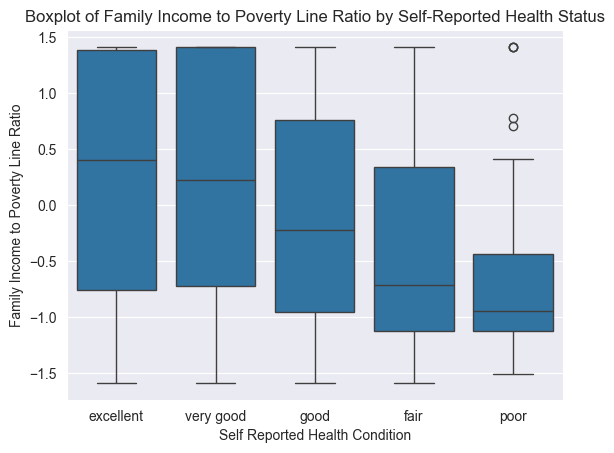

In [5]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

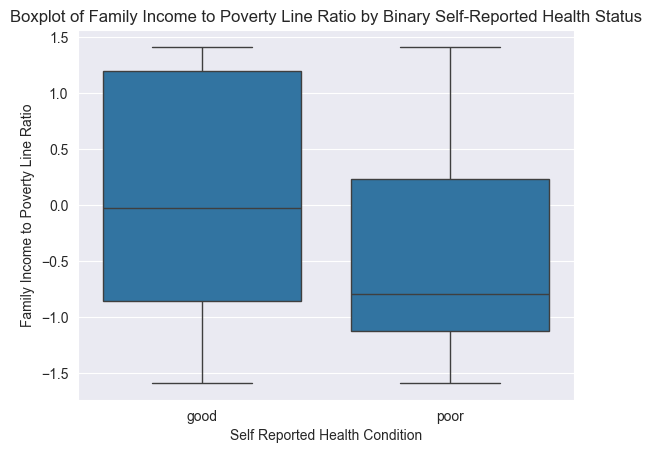

In [6]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

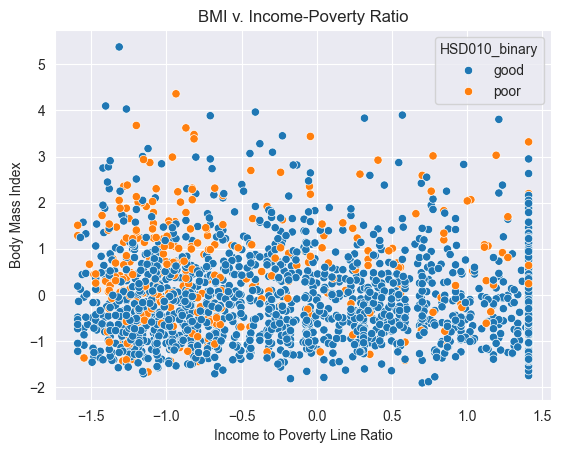

In [7]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010_binary", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [8]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

In [9]:
nhanes_scaled.shape

(2064, 241)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [10]:
# specify and fit a PCA model
# ----
pca = PCA(n_components=20)
pca = pca.fit(nhanes_scaled)

In [11]:
# create a dataframe of explained variance ratio
# ----
scrplot = pd.DataFrame(data = pca.explained_variance_ratio_, 
                       columns = ['exp_var_ratio'])
scrplot.loc[:, 'nth_pc'] = np.arange(1, pca.n_components_ + 1)
scrplot = scrplot.set_index('nth_pc')
scrplot.head()

,exp_var_ratio
nth_pc,
1,0.102020
2,0.076230
3,0.043712
4,0.028822
5,0.023571


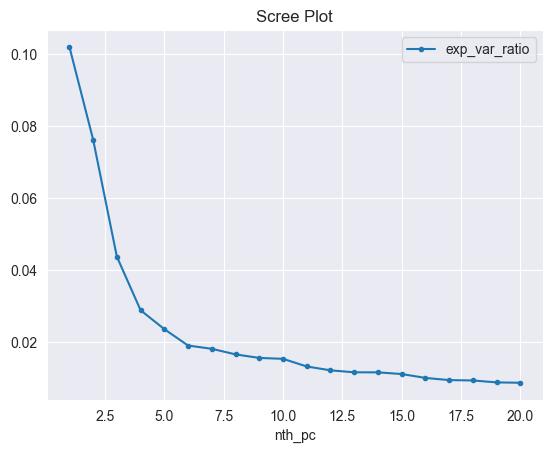

In [12]:
# draw a scree plot
# ----
scrplot.plot(title='Scree Plot', marker='.');

**Choose the number of components:** 

The scree plot reveals an "elbow" after the fourth component, indicating a significant drop in the proportion of variance explained by subsequent principal components (ISLP, p. 514). Notably, the fifth component accounts for only 2.4% of the data's variance. Based on this observation, I have selected four components.

### Barplot of Components

In [13]:
# retrain the model with n_components=4
# ----
pca = PCA(n_components=4).fit(nhanes_scaled)
pca.explained_variance_ratio_

array([0.10201961, 0.07623011, 0.04371192, 0.02882171])

In [14]:
# create a dataframe of explained variance ratio
# ----
barplot = pd.DataFrame(data = pca.explained_variance_ratio_, 
                       columns = ['exp_var_ratio'])
barplot.loc[:, 'nth_pc'] = np.arange(1, pca.n_components_ + 1)
barplot = barplot.set_index('nth_pc')
barplot

,exp_var_ratio
nth_pc,
1,0.102020
2,0.076230
3,0.043712
4,0.028822


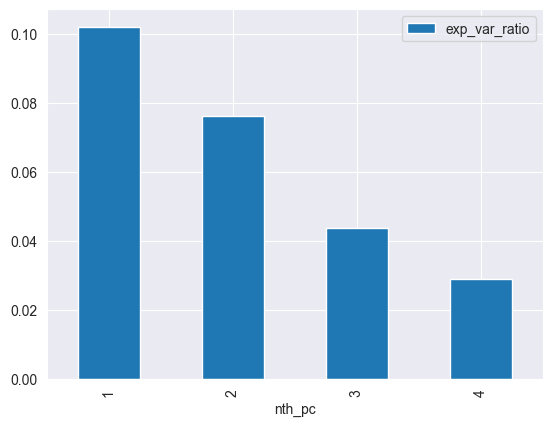

In [15]:
# draw a bar plot of components
# ----
barplot.plot(kind='bar');

### How many components will you use to fit a supervised learning model?

**Answer Here:**

As discussed earlier, I will select four components, as the explained variance decreases significantly beyond this point. However, as noted in ISLP (p. 515): *“If we compute principal components for use in a supervised analysis ... then there is a simple and objective way to determine how many principal components to use: we can treat the number of principal component score vectors to be used in the regression as a tuning parameter to be selected via cross-validation or a related approach.”* Therefore, while four components may suffice, additional components could be tested objectively to determine if they yield better results.

### 2D Scatterplot of the first two components

In [16]:
# view principal component loadings of the 241 features
pd.DataFrame(pca.components_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240
0,-2.761226e-18,-0.000643,-1.720194e-20,0.004001,0.017487,0.002562,-0.010297,-0.007398,0.009323,-0.010322,0.011467,-0.010450,0.008568,0.089955,0.181617,0.164204,0.140134,0.090492,0.125920,0.176109,0.164232,0.167727,0.143017,0.118342,0.127492,0.120697,0.098234,0.032521,0.038203,0.143611,0.148127,0.140592,0.120421,0.132627,0.082338,0.127117,0.119876,0.144914,0.117381,0.056365,0.080640,0.058204,0.144853,0.182538,0.157961,0.138860,0.150868,0.143764,0.156793,0.161782,0.152029,0.073806,0.109899,0.110721,0.108131,0.120316,0.071938,0.128142,0.167702,0.157921,0.129794,0.164787,0.110306,0.141374,0.119825,0.106543,-0.033599,-0.011540,-0.017471,-0.015808,-0.006180,-0.004737,-0.003616,-0.008015,0.017005,0.069950,-0.011878,0.045836,0.008801,-0.004316,-0.009823,-0.008938,-0.000612,-0.007047,-0.040605,-0.035811,-0.044285,-0.032018,-0.039565,-0.042725,-0.042287,-0.041204,-0.039609,-0.039659,-0.030698,-0.035761,-0.044018,-0.043625,-0.013100,-0.010093,-0.038257,-0.039777,-0.040969,-0.029310,-0.037572,-0.042138,-0.039821,-0.042090,-0.038956,-0.036840,-0.027988,-0.038504,-0.039462,-0.043037,-0.010195,-0.011074,-0.011074,0.007931,0.007931,-0.013347,-0.004823,-0.005164,0.006621,0.000930,0.009635,-0.002589,-0.006926,0.003107,-0.004206,0.039060,0.047560,0.046027,0.005476,0.011358,0.018465,-0.020178,-0.019246,-0.003704,-0.005285,0.004235,-0.005733,0.000824,-0.001906,0.000359,0.009862,-0.005285,0.022509,0.0,0.0,-0.066478,-0.017505,-0.001844,-0.000683,0.001060,-0.005431,-0.001783,-0.010254,0.012435,0.016025,-0.005997,0.004045,0.008428,0.003983,0.005533,-0.014142,-0.023448,0.000882,0.035748,-0.009209,0.026318,0.026136,0.002349,-0.005214,0.037651,0.038182,0.036831,0.003030,0.000103,0.013180,-0.002163,0.0,0.015609,0.008061,0.005054,0.026853,0.018085,0.035698,0.023118,0.030766,0.025433,0.020645,-0.026739,-0.026471,0.020571,0.029404,0.006031,-0.007873,-0.003589,-0.002286,0.005508,0.002180,0.026705,-0.009426,-0.037185,-0.001546,0.002373,0.009409,0.023682,0.005948,-0.002537,-0.005138,-0.014285,-0.008505,0.027697,0.012104,0.006556,0.023574,0.017717,-0.016560,-0.004136,0.038902,0.035335,0.037381,0.004694,0.010346,0.007916,0.002106,0.003512,-0.003802,0.007463,-0.011046,-0.026669,0.017998,-0.023927,-0.011375,-0.030444,0.0,0.006748,-0.005185,-0.015929,0.005240
1,6.513616e-17,-0.006048,3.427532e-19,0.007050,0.002873,-0.021953,0.021641,0.008215,0.001760,-0.004650,-0.004518,-0.019868,-0.015086,0.017435,0.050490,0.042018,0.039175,0.034468,0.018920,0.048926,0.050105,0.046146,0.033865,0.041741,0.022779,0.030297,0.015911,-0.003391,0.003135,0.031790,0.041362,0.038531,0.026850,0.026377,0.014834,0.027327,0.023296,0.048399,0.029899,-0.009365,0.018415,0.007473,0.030586,0.042108,0.034272,0.033820,0.034555,0.030333,0.042002,0.042197,0.044219,0.042631,0.030166,0.030447,0.034206,0.032898,0.025070,0.036612,0.049667,0.050729,0.045177,0.043594,0.035365,0.033094,0.027461,0.039208,0.007165,-0.027272,0.018966,-0.010436,0.018754,0.037458,0.015745,0.000841,0.057756,0.018525,0.058430,0.039424,0.054419,0.077828,0.020205,0.033946,0.001202,0.002202,0.141934,0.158123,0.164694,0.145820,0.164718,0.176963,0.178332,0.179868,0.176051,0.168649,0.145935,0.161834,

In [17]:
# transform the nhanes_scaled data (n=2064) to pricipal component scores
# ----
nhanes_pcs = pd.DataFrame(data = pca.transform(nhanes_scaled), 
                          columns = ['Z1', 'Z2', 'Z3', 'Z4'])
nhanes_pcs

,Z1,Z2,Z3,Z4
0,9.527811,-0.816224,-1.867099,-2.109866
1,-5.838339,-3.692573,3.805733,-1.029845
2,-0.719454,-2.573201,0.907874,-4.755616
3,3.533627,-2.576982,-3.249120,-0.405808
4,-6.872094,-4.194241,0.886806,-0.848849
...,...,...,...,...
2059,2.643319,-1.689356,-0.702589,-0.538113
2060,1.037906,-0.118065,5.556443,1.630458
2061,1.130253,-0.970432,3.415375,1.206262
2062,7.145093,-0.376753,1.753520,-0.938260


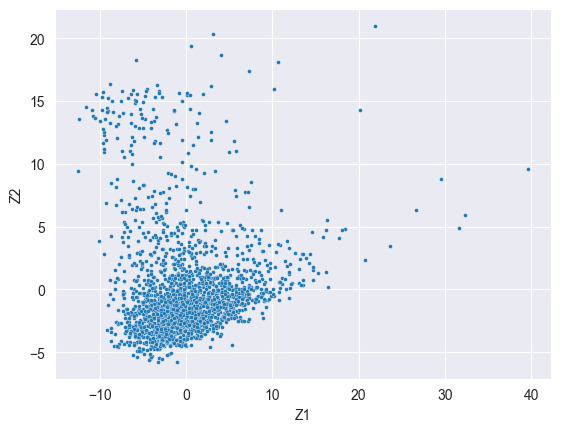

In [18]:
# draw a scatterplot
# ----
sns.scatterplot(data=nhanes_pcs, x='Z1', y='Z2', s=8);

In [19]:
# create a binary variable of HSD010
# ----
hsd010_poor2 = hsd010.replace([1,2,3,4,5], [0,0,0,1,1])
hsd010_poor2

0       0
1       0
2       0
3       0
4       0
       ..
2059    0
2060    0
2061    1
2062    0
2063    0
Name: HSD010, Length: 2064, dtype: int64

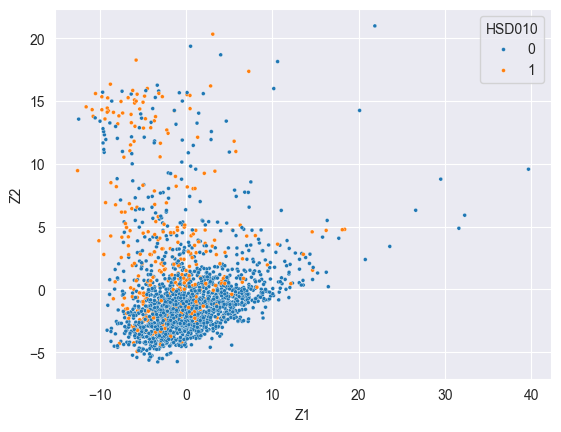

In [20]:
# draw a scatterplot again
# ----
nhanes_reduced = pd.concat([nhanes_pcs, hsd010_poor2], axis=1)
sns.scatterplot(data=nhanes_reduced,
                x='Z1', y='Z2', hue='HSD010', s=8);

**Analyzing the Plot:**

The first two principal components account for approximately 18% of the data's variance. Does this variance explain the reported patterns in health conditions? Notably, the most interesting observation is that respondents with relatively lower Z1 (scores on the first principal component) and relatively higher Z2 (scores on the second principal component) report a significantly higher percentage of poor health. In other words, samples located in the upper-left region of the scatter plot tend to exhibit poorer health conditions.

In conclusion, I hypothesize that while the first principal component captures the most variance among respondents, the second principal component represents a linear combination of health-related variables indicative of health condition. I will explore this hypothesis further in the next section through clustering analysis.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

**Answer Here:**

I chose K-means clustering for three key reasons. First, K-means requires specifying the desired number of clusters (K) beforehand, which aligns well with my observation of three or four distinct clusters in the scatter plot (upper left, middle left, right-hand side, and possibly others). This makes it a direct method to test the hypothesis. Second, while hierarchical clustering offers more detailed interpretability, it depends heavily on the type of linkage used, which could introduce unnecessary complexity for this task. Third, although density-based methods like DBSCAN excel at identifying patterns such as circular shapes, the scatter plot suggests a simpler clustering structure better suited to K-means, as it aims to minimize within-cluster variation while maximizing between-cluster variation.

### Cluster nhanes

In [21]:
# use a loop to find the best k
# ----
k = range(1, 21) 
inertia = []

for _ in k:
    kmeans = KMeans(n_clusters=_, n_init=5, random_state=224)
    kmeans.fit(nhanes_scaled)  
    inertia.append(kmeans.inertia_)

In [22]:
# create a dataframe of inertia
# ----
scrplot = pd.concat([pd.DataFrame(inertia, columns=['inertia']), 
                     pd.DataFrame(k, columns=['nclusters'])], axis=1).set_index('nclusters')
scrplot.head()

,inertia
nclusters,
1,485040.000000
2,456046.871997
3,430160.982926
4,418156.185430
5,411426.150492


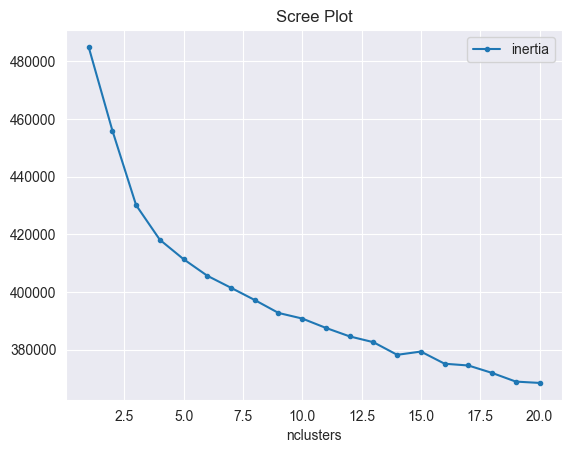

In [23]:
# draw a scree plot
# ----
scrplot.plot(title='Scree Plot', marker='.');

**Choose the number of clusters:** 

Based on the scree plot, there is an "elbow" after the fourth component as the scree plot shows, similar to the result of PCA. Therefore, I choose 4 clusters. 

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [24]:
# retrain the model with n_clusters=4
# ----
kmeans = KMeans(n_clusters=4, n_init=5, random_state=224).fit(nhanes_scaled)
kmeans.inertia_

418156.18542955944

In [25]:
# concat the result of K-means and PCA
# ----
nhanes_reduced = pd.concat([nhanes_reduced, 
                        pd.DataFrame(kmeans.labels_, columns=['kmeans'])], axis=1)
nhanes_reduced.head()

,Z1,Z2,Z3,Z4,HSD010,kmeans
0,9.527811,-0.816224,-1.867099,-2.109866,0,1
1,-5.838339,-3.692573,3.805733,-1.029845,0,2
2,-0.719454,-2.573201,0.907874,-4.755616,0,3
3,3.533627,-2.576982,-3.249120,-0.405808,0,3
4,-6.872094,-4.194241,0.886806,-0.848849,0,2


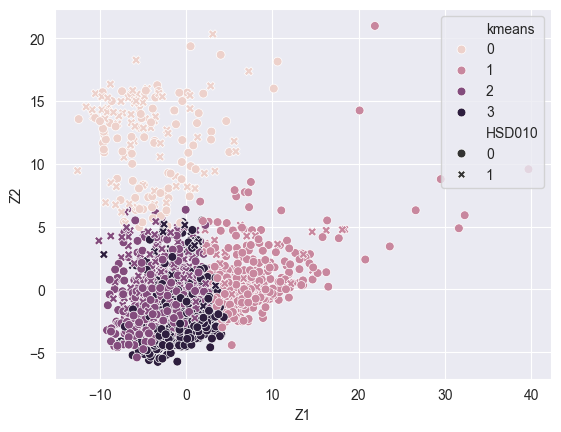

In [26]:
# draw a scatter plot again
sns.scatterplot(data=nhanes_reduced,
                x='Z1', y='Z2', hue='kmeans', style='HSD010', s=40);

In [27]:
# view outcome differences between groups 
nhanes_reduced.groupby('kmeans')['HSD010'].mean()

kmeans
0    0.472393
1    0.090226
2    0.222059
3    0.082725
Name: HSD010, dtype: float64

**Analyzing the Plot:**

The four clusters identified using the K-means method appear to align well with the patterns observed in the 2D scatterplot of the first two principal components. Group-by calculations reveal that two clusters have significantly higher percentages of respondents reporting poor health (47% and 22%) compared to the other two clusters (9% and 8%).

Interestingly, while clusters 2 and 3 are geographically close in the scatterplot of the first two PCs, their outcomes differ markedly, with 22% of respondents in cluster 2 reporting poor health compared to only 8% in cluster 3. This suggests that these clusters may differ along dimensions captured by the third principal component or others beyond the first two, which are not visible in the 2D scatterplot.

In [28]:
# create a dataframe for BMI plotting
# ----
BMIplot = nhanes_scaled[['INDFMPIR', 'BMXBMI']].reset_index(drop=True)
BMIplot = pd.concat([BMIplot, pd.DataFrame(kmeans.labels_, columns=['kmeans'])], axis=1)
BMIplot = pd.concat([BMIplot, hsd010_poor2], axis=1)
BMIplot

,INDFMPIR,BMXBMI,kmeans,HSD010
0,1.412214,-1.001972,1,0
1,-0.642017,-0.618783,2,0
2,0.192890,-1.636215,3,0
3,1.412214,-0.565929,3,0
4,0.252955,-0.341301,2,0
...,...,...,...,...
2059,0.343053,-0.341301,3,0
2060,-1.092507,0.081527,2,0
2061,-1.591048,1.508575,2,1
2062,0.589320,-0.499862,1,0


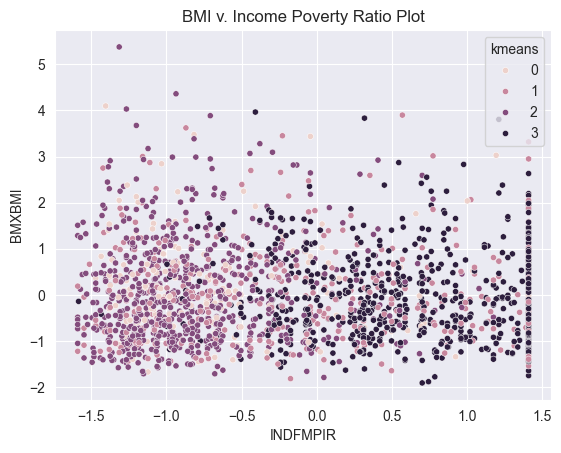

In [29]:
# draw a scatter plot again
sns.scatterplot(data=BMIplot,
                x='INDFMPIR', y='BMXBMI', hue='kmeans', s=20)
plt.title("BMI v. Income Poverty Ratio Plot");

**Analyzing the Plot:**

We know from the previous plot that cluster 0 and cluster 2 have higher prevalence of reporting poor health (47% and 22%, respectively). And we can see that these two clusters concentrate on the left side of the BMI v. Income Poverty Ratio Plot. It seems that respondents with lower income concentrate in these two clusters. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [30]:
# retrain the model with PCA components
# ----
kmeans = KMeans(n_clusters=4, n_init=5, random_state=224)
kmeans.fit(nhanes_pcs)
kmeans.inertia_

55371.16897134103

In [31]:
# incorporate the results into previously created dataframe
# ----
nhanes_reduced = pd.concat([nhanes_reduced, 
                        pd.DataFrame(kmeans.labels_, columns=['kmeans_pca'])], axis=1)
nhanes_reduced.head()

,Z1,Z2,Z3,Z4,HSD010,kmeans,kmeans_pca
0,9.527811,-0.816224,-1.867099,-2.109866,0,1,2
1,-5.838339,-3.692573,3.805733,-1.029845,0,2,1
2,-0.719454,-2.573201,0.907874,-4.755616,0,3,0
3,3.533627,-2.576982,-3.249120,-0.405808,0,3,0
4,-6.872094,-4.194241,0.886806,-0.848849,0,2,1


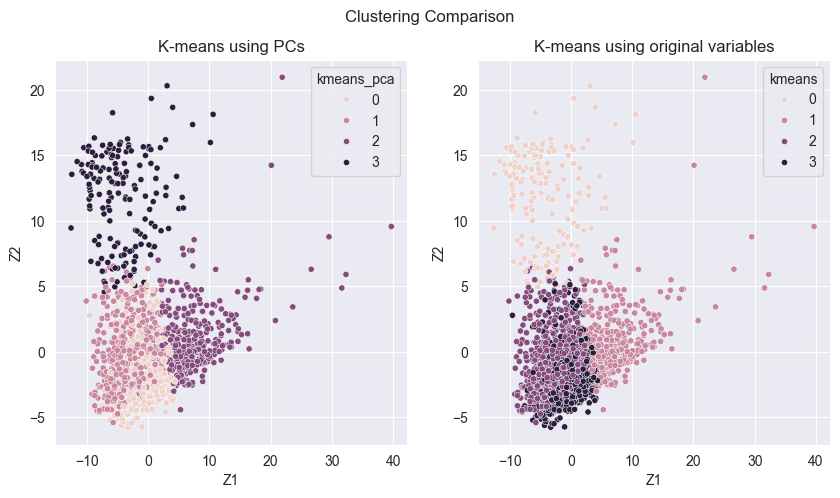

In [32]:
# draw scatterplots
# ----
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Clustering Comparison')

sns.scatterplot(ax=axes[0],
                data=nhanes_reduced, x='Z1', y='Z2', hue='kmeans_pca', s=20)
axes[0].set_title('K-means using PCs')

sns.scatterplot(ax=axes[1],
                data=nhanes_reduced, x='Z1', y='Z2', hue='kmeans', s=20)
axes[1].set_title('K-means using original variables');

In [33]:
# view outcome differences between groups using PCs
nhanes_reduced.groupby('kmeans_pca')['HSD010'].mean()

kmeans_pca
0    0.085106
1    0.226852
2    0.090686
3    0.469136
Name: HSD010, dtype: float64

In [34]:
# view outcome differences between groups using original variables
nhanes_reduced.groupby('kmeans')['HSD010'].mean()

kmeans
0    0.472393
1    0.090226
2    0.222059
3    0.082725
Name: HSD010, dtype: float64

**Results Discussion:**

A similar clustering pattern emerges whether the K-means algorithm is trained using principal components or the original variables. While the difference in the HSD010 outcome is slightly more pronounced when using the original variables, the difference is minimal. This suggests that the first four principal components effectively capture meaningful patterns in the data.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [35]:
# partition data
# ----
y = hsd010_poor2
X = nhanes_scaled

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .2, 
                                                    random_state = 224)

In [36]:
# create neural network model
# ----
model = Sequential()
model.add(Dense(360, input_dim=241, kernel_initializer='normal', activation='relu'))
model.add(Dense(241, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

In [37]:
# compile model
# ----
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
# fit model
# ----
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=100,
          verbose=2);

Epoch 1/10
17/17 - 0s - loss: 0.4183 - accuracy: 0.8207 - val_loss: 0.3545 - val_accuracy: 0.8475 - 253ms/epoch - 15ms/step
Epoch 2/10
17/17 - 0s - loss: 0.2889 - accuracy: 0.8825 - val_loss: 0.3471 - val_accuracy: 0.8475 - 34ms/epoch - 2ms/step
Epoch 3/10
17/17 - 0s - loss: 0.2236 - accuracy: 0.9079 - val_loss: 0.3428 - val_accuracy: 0.8596 - 36ms/epoch - 2ms/step
Epoch 4/10
17/17 - 0s - loss: 0.1636 - accuracy: 0.9382 - val_loss: 0.3795 - val_accuracy: 0.8547 - 34ms/epoch - 2ms/step
Epoch 5/10
17/17 - 0s - loss: 0.1082 - accuracy: 0.9691 - val_loss: 0.4192 - val_accuracy: 0.8450 - 36ms/epoch - 2ms/step
Epoch 6/10
17/17 - 0s - loss: 0.0689 - accuracy: 0.9879 - val_loss: 0.4668 - val_accuracy: 0.8426 - 66ms/epoch - 4ms/step
Epoch 7/10
17/17 - 0s - loss: 0.0362 - accuracy: 0.9939 - val_loss: 0.5227 - val_accuracy: 0.8475 - 39ms/epoch - 2ms/step
Epoch 8/10
17/17 - 0s - loss: 0.0184 - accuracy: 0.9982 - val_loss: 0.6338 - val_accuracy: 0.8547 - 39ms/epoch - 2ms/step
Epoch 9/10
17/17 - 0s 

### Neural Network on Principal Components

In [39]:
# partition data
# ----
y = hsd010_poor2
X = nhanes_pcs

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .2, 
                                                    random_state = 224)

In [40]:
# create neural network model
# ----
model = Sequential()
model.add(Dense(8, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

In [41]:
# compile model
# ----
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
# fit model
# ----
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=100,
          verbose=2);

Epoch 1/10
17/17 - 0s - loss: 0.6889 - accuracy: 0.8389 - val_loss: 0.6836 - val_accuracy: 0.8402 - 182ms/epoch - 11ms/step
Epoch 2/10
17/17 - 0s - loss: 0.6783 - accuracy: 0.8389 - val_loss: 0.6703 - val_accuracy: 0.8402 - 18ms/epoch - 1ms/step
Epoch 3/10
17/17 - 0s - loss: 0.6618 - accuracy: 0.8389 - val_loss: 0.6493 - val_accuracy: 0.8402 - 19ms/epoch - 1ms/step
Epoch 4/10
17/17 - 0s - loss: 0.6360 - accuracy: 0.8389 - val_loss: 0.6164 - val_accuracy: 0.8402 - 18ms/epoch - 1ms/step
Epoch 5/10
17/17 - 0s - loss: 0.5980 - accuracy: 0.8389 - val_loss: 0.5700 - val_accuracy: 0.8402 - 18ms/epoch - 1ms/step
Epoch 6/10
17/17 - 0s - loss: 0.5473 - accuracy: 0.8389 - val_loss: 0.5153 - val_accuracy: 0.8402 - 16ms/epoch - 959us/step
Epoch 7/10
17/17 - 0s - loss: 0.4935 - accuracy: 0.8389 - val_loss: 0.4630 - val_accuracy: 0.8402 - 19ms/epoch - 1ms/step
Epoch 8/10
17/17 - 0s - loss: 0.4478 - accuracy: 0.8389 - val_loss: 0.4234 - val_accuracy: 0.8402 - 18ms/epoch - 1ms/step
Epoch 9/10
17/17 - 0

### Logistic Regression on Principal Components

In [43]:
# view
hsd010_poor2.value_counts(normalize=True)

HSD010
0    0.839147
1    0.160853
Name: proportion, dtype: float64

In [44]:
# specify and train the model
# ----
logit = LogisticRegression()
logit = logit.fit(X_train, y_train)

In [45]:
# make confusion matrix
logit_df = pd.concat([pd.DataFrame(logit.predict(X_test), columns=['pred']),
                      y_test.reset_index(drop=True)], axis=1)

pd.crosstab(logit_df['pred'], logit_df['HSD010'], margins=True)

HSD010,0,1,All
pred,,,
0,334,46,380
1,13,20,33
All,347,66,413


In [46]:
# calculate accuracy score
print((334+20)/413)

0.8571428571428571


### Neural Network on Principal Components + Cluster Membership

In [47]:
# partition data
# ----
y = hsd010_poor2
X = nhanes_reduced.drop(columns=['HSD010', 'kmeans_pca'])

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .2, 
                                                    random_state = 224)

In [48]:
# create neural network model
# ----
model = Sequential()
model.add(Dense(10, input_dim=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(5, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

In [49]:
# compile model
# ----
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
# fit model
# ----
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=100,
          verbose=2);

Epoch 1/10
17/17 - 0s - loss: 0.6876 - accuracy: 0.8359 - val_loss: 0.6819 - val_accuracy: 0.8402 - 188ms/epoch - 11ms/step
Epoch 2/10
17/17 - 0s - loss: 0.6750 - accuracy: 0.8389 - val_loss: 0.6661 - val_accuracy: 0.8402 - 18ms/epoch - 1ms/step
Epoch 3/10
17/17 - 0s - loss: 0.6536 - accuracy: 0.8389 - val_loss: 0.6388 - val_accuracy: 0.8402 - 19ms/epoch - 1ms/step
Epoch 4/10
17/17 - 0s - loss: 0.6182 - accuracy: 0.8389 - val_loss: 0.5953 - val_accuracy: 0.8402 - 18ms/epoch - 1ms/step
Epoch 5/10
17/17 - 0s - loss: 0.5666 - accuracy: 0.8389 - val_loss: 0.5366 - val_accuracy: 0.8402 - 19ms/epoch - 1ms/step
Epoch 6/10
17/17 - 0s - loss: 0.5042 - accuracy: 0.8389 - val_loss: 0.4752 - val_accuracy: 0.8402 - 18ms/epoch - 1ms/step
Epoch 7/10
17/17 - 0s - loss: 0.4480 - accuracy: 0.8389 - val_loss: 0.4265 - val_accuracy: 0.8402 - 18ms/epoch - 1ms/step
Epoch 8/10
17/17 - 0s - loss: 0.4098 - accuracy: 0.8389 - val_loss: 0.3964 - val_accuracy: 0.8402 - 18ms/epoch - 1ms/step
Epoch 9/10
17/17 - 0s 

**Question: Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?**

Among the models trained, the neural network using the original features outperforms the other two neural network models, while logistic regression trained on principal components also performs well.

Neural networks are highly flexible models. When trained on principal components (or principal components combined with clustering membership), they avoid overfitting and maintain stable validation accuracy scores across all ten epochs. In contrast, the neural network trained on original features exhibits signs of overfitting; while its accuracy score steadily increases (approaching 1 from epoch 1 to epoch 10), the validation accuracy declines. This bias-variance tradeoff suggests that optimizing the neural network's structure, such as adjusting the number of hidden layers or neurons per layer, could potentially improve its performance.

However, given the goal of studying social determinants of public health outcomes, I have chosen the logistic regression model trained on principal components. This model offers higher interpretability without sacrificing much predictive power, making it more suitable for the task.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA addresses the dimensionality problem by transforming the original features into principal components, reducing 241 features to 4 components in this case. Clustering, on the other hand, simplifies the complexity of the samples by grouping them based on their proximity, reducing 2,064 samples into 4 distinct clusters. In essence, PCA reduces complexity by summarizing variables, while clustering reduces idiosyncrasies among samples.

PCA facilitates visualization and data exploration by reducing the number of features. For instance, plotting the data using the first two principal components revealed some interesting patterns. Conversely, clustering helps identify outcome differences across groups. As demonstrated, two clusters show significantly higher percentages of poor health reports (47% and 22%) compared to the other two clusters (9% and 8%).

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

    Yes, there are two key advantages. First, while clustering helps identify outcome differences across groups, visualizing clusters in high-dimensional spaces can be challenging. Plotting the clustering results on the scatterplot of the first two principal components provides an intuitive way to explore the data. Second, the inertia scree plot shows that as the number of clusters (K) increases, the gain in inertia diminishes, suggesting that dividing into more clusters makes the algorithm more susceptible to noise. Applying PCA before clustering reduces noise, resulting in more stable clustering outcomes.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

When working with big data, the sheer number of features can be overwhelming. Unsupervised techniques like PCA and clustering can be automated to uncover and summarize interesting patterns in the data. With careful interpretation and further exploration, these techniques can yield valuable insights. Additionally, unsupervised methods can enhance the performance of downstream supervised learning tasks. For example, PCA reduces noise in the data while preserving meaningful variance, enabling supervised machine learning models to perform more effectively when trained on the processed data.